# Xavier

## Using pytorch implement  Xavier way

In [26]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn,optim
from torch.nn import functional as F 
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torch.utils.data import random_split
import random

import seaborn as sns

In [13]:
# generation some data
def tensorGenReg(num_examples=1000, w=[2, -1, 1], bias=True, delta=0.01, deg=1):
    """回归类数据集创建函数。

    :param num_examples: 创建数据集的数据量
    :param w: 包括截距的（如果存在）特征系数向量
    :param bias：是否需要截距
    :param delta：扰动项取值
    :param deg：方程次数
    :return: 生成的特征张和标签张量
    """

    if bias == True:
        num_inputs = len(w) - 1  # 特征张量
        features_true = torch.randn(num_examples, num_inputs)  # 不包含全是1的列的特征张量
        w_true = torch.tensor(w[:-1]).reshape(-1, 1).float()  # 自变量系数
        b_true = torch.tensor(w[-1]).float()  # 截距
        if num_inputs == 1:  # 若输入特征只有1个，则不能使用矩阵乘法
            labels_true = torch.pow(features_true, deg) * w_true + b_true
        else:
            labels_true = torch.mm(torch.pow(features_true, deg), w_true) + b_true
        features = torch.cat((features_true, torch.ones(len(features_true), 1)), 1)  # 在特征张量的最后添加一列全是1的列
        labels = labels_true + torch.randn(size=labels_true.shape) * delta

    else:
        num_inputs = len(w)
        features = torch.randn(num_examples, num_inputs)
        w_true = torch.tensor(w).reshape(-1, 1).float()
        if num_inputs == 1:
            labels_true = torch.pow(features, deg) * w_true
        else:
            labels_true = torch.mm(torch.pow(features, deg), w_true)
        labels = labels_true + torch.randn(size=labels_true.shape) * delta
    return features, labels

class GenData(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.lens = len(features)

    def __getitem__(self, index):
        return self.features[index, :], self.labels[index]

    def __len__(self):
        return self.lens


def split_loader(features, labels, batch_size=10, rate=0.7):
    """数据封装、切分和加载函数：

    :param features：输入的特征
    :param labels: 数据集标签张量
    :param batch_size：数据加载时的每一个小批数据量
    :param rate: 训练集数据占比
    :return：加载好的训练集和测试集
    """
    data = GenData(features, labels)
    num_train = int(data.lens * 0.7)
    num_test = data.lens - num_train
    data_train, data_test = random_split(data, [num_train, num_test])
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)
    return (train_loader, test_loader)


In [14]:
torch.manual_seed(420)

features, labels = tensorGenReg(w=[2,-1],bias=False,deg=2)

train_loader, test_loader = split_loader(features,labels)

In [15]:
lr = 0.03
num_epochs = 20 

In [16]:
class Sigmoid_class3(nn.Module):
    def __init__(self, in_features=2, n_hidden1=4, n_hidden2=4, n_hidden3=4, out_features=1, BN_model=None):
        super(Sigmoid_class3, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1)
        self.normalize1 = nn.BatchNorm1d(n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.normalize2 = nn.BatchNorm1d(n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3)
        self.normalize3 = nn.BatchNorm1d(n_hidden3)
        self.linear4 = nn.Linear(n_hidden3, out_features)
        self.BN_model = BN_model

    def forward(self, x):
        if self.BN_model == None:
            z1 = self.linear1(x)
            p1 = torch.sigmoid(z1)
            z2 = self.linear2(p1)
            p2 = torch.sigmoid(z2)
            z3 = self.linear3(p2)
            p3 = torch.sigmoid(z3)
            out = self.linear4(p3)
        elif self.BN_model == 'pre':
            z1 = self.normalize1(self.linear1(x))
            p1 = torch.sigmoid(z1)
            z2 = self.normalize2(self.linear2(p1))
            p2 = torch.sigmoid(z2)
            z3 = self.normalize3(self.linear3(p2))
            p3 = torch.sigmoid(z3)
            out = self.linear4(p3)
        elif self.BN_model == 'post':
            z1 = self.linear1(x)
            p1 = torch.sigmoid(z1)
            z2 = self.linear2(self.normalize1(p1))
            p2 = torch.sigmoid(z2)
            z3 = self.linear3(self.normalize2(p2))
            p3 = torch.sigmoid(z3)
            out = self.linear4(self.normalize3(p3))
        return out

In [19]:
sigmoid_model3 = Sigmoid_class3()
sigmoid_model3_init = Sigmoid_class3()

for m in sigmoid_model3_init.modules():
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)

In [20]:
model_l = [sigmoid_model3, sigmoid_model3_init]           
name_l = ['sigmoid_model3', 'sigmoid_model3_init']

In [22]:
def fit(net, criterion, optimizer, batchdata, epochs=3, cla=False):
    """模型训练函数

    :param net：待训练的模型
    :param criterion: 损失函数
    :param optimizer：优化算法
    :param batchdata: 训练数据集
    :param cla: 是否是分类问题
    :param epochs: 遍历数据次数
    """
    for epoch in range(epochs):
        for X, y in batchdata:
            if cla == True:
                y = y.flatten().long()  # 如果是分类问题，需要对y进行整数转化
            yhat = net.forward(X)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def mse_cal(data_loader, net):
    """mse计算函数

    :param data_loader：加载好的数据
    :param net: 模型
    :return：根据输入的数据，输出其MSE计算结果
    """
    data = data_loader.dataset  # 还原Dataset类
    X = data[:][0]  # 还原数据的特征
    y = data[:][1]  # 还原数据的标签
    yhat = net(X)
    return F.mse_loss(yhat, y)


def model_comparison(model_l,
                     name_l,
                     train_data,
                     test_data,
                     num_epochs=20,
                     criterion=nn.MSELoss(),
                     optimizer=optim.SGD,
                     lr=0.03,
                     cla=False,
                     eva=mse_cal):
    """模型对比函数：

    :param model_l：模型序列
    :param name_l：模型名称序列
    :param train_data：训练数据
    :param test_data：测试数据
    :param num_epochs：迭代轮数
    :param criterion: 损失函数
    :param lr: 学习率
    :param cla: 是否是分类模型
    :param eva: 模型评估指标
    :return：评估指标张量矩阵
    """
    # 模型评估指标矩阵
    train_l = torch.zeros(len(model_l), num_epochs)
    test_l = torch.zeros(len(model_l), num_epochs)
    # 模型训练过程
    for epochs in range(num_epochs):
        for i, model in enumerate(model_l):
            model.train()
            fit(net=model,
                criterion=criterion,
                optimizer=optimizer(model.parameters(), lr=lr),
                batchdata=train_data,
                epochs=epochs,
                cla=cla)
            model.eval()
            train_l[i][epochs] = eva(train_data, model).detach()
            test_l[i][epochs] = eva(test_data, model).detach()
    return train_l, test_l

In [23]:
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = 2, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

In [24]:
def weights_vp(model, att="grad"):
    """观察各层参数取值和梯度的小提琴图绘图函数。

    :param model：观察对象（模型）
    :param att：选择参数梯度（grad）还是参数取值（weights）进行观察
    :return: 对应att的小提琴图
    """
    vp = []
    for i, m in enumerate(model.modules()):
        if isinstance(m, nn.Linear):
            if att == "grad":
                vp_x = m.weight.grad.detach().reshape(-1, 1).numpy()
            else:
                vp_x = m.weight.detach().reshape(-1, 1).numpy()
            vp_y = np.full_like(vp_x, i)
            vp_a = np.concatenate((vp_x, vp_y), 1)
            vp.append(vp_a)
    vp_r = np.concatenate((vp), 0)
    ax = sns.violinplot(y=vp_r[:, 0], x=vp_r[:, 1])
    ax.set(xlabel='num_hidden', title=att)

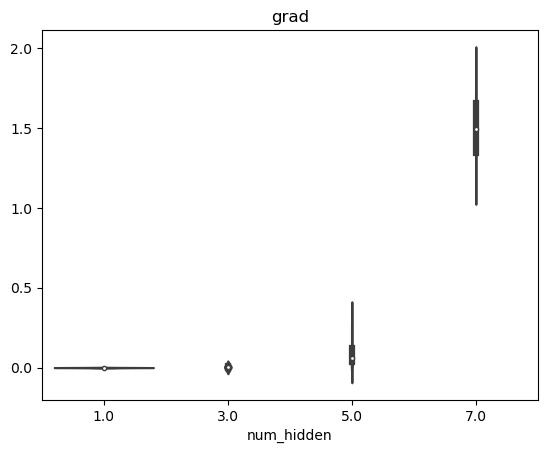

In [27]:
weights_vp(sigmoid_model3, att="grad")

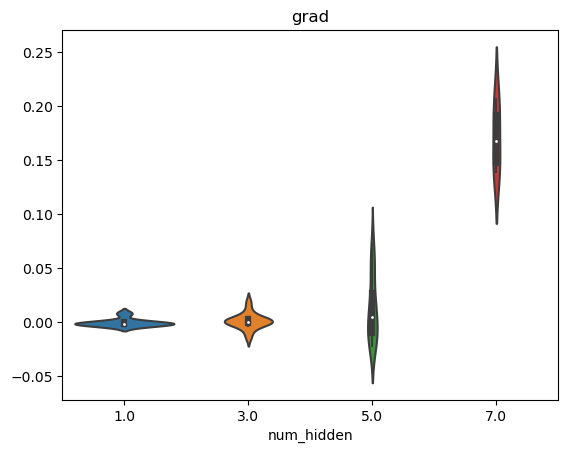

In [28]:
weights_vp(sigmoid_model3_init, att="grad")

In [29]:
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

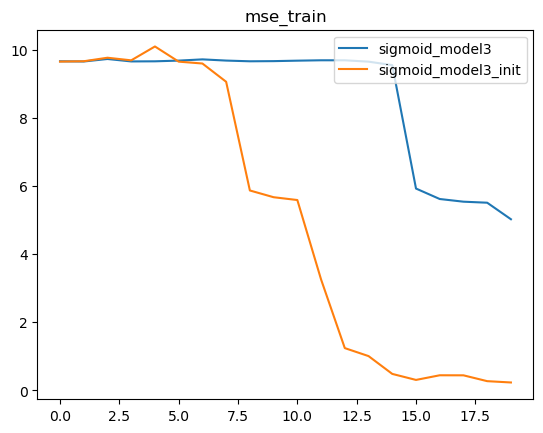

In [30]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

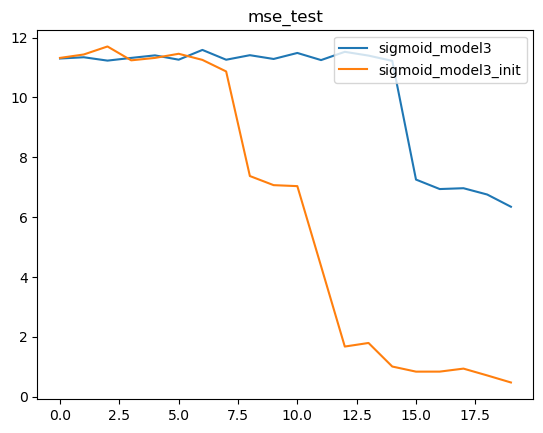

In [31]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

# Kaiming

In [32]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, 1], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

# 初始核心参数
lr = 0.001
num_epochs = 20

In [33]:
class ReLU_class3(nn.Module):
    def __init__(self, in_features=2, n_hidden1=4, n_hidden2=4, n_hidden3=4, out_features=1, bias=True, BN_model=None):
        super(ReLU_class3, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden1, bias=bias)
        self.normalize1 = nn.BatchNorm1d(n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2, bias=bias)
        self.normalize2 = nn.BatchNorm1d(n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, n_hidden3, bias=bias)
        self.normalize3 = nn.BatchNorm1d(n_hidden3)
        self.linear4 = nn.Linear(n_hidden3, out_features, bias=bias)
        self.BN_model = BN_model

    def forward(self, x):
        if self.BN_model == None:
            z1 = self.linear1(x)
            p1 = torch.relu(z1)
            z2 = self.linear2(p1)
            p2 = torch.relu(z2)
            z3 = self.linear3(p2)
            p3 = torch.relu(z3)
            out = self.linear4(p3)
        elif self.BN_model == 'pre':
            z1 = self.normalize1(self.linear1(x))
            p1 = torch.relu(z1)
            z2 = self.normalize2(self.linear2(p1))
            p2 = torch.relu(z2)
            z3 = self.normalize3(self.linear3(p2))
            p3 = torch.relu(z3)
            out = self.linear4(p3)
        elif self.BN_model == 'post':
            z1 = self.linear1(x)
            p1 = torch.relu(z1)
            z2 = self.linear2(self.normalize1(p1))
            p2 = torch.relu(z2)
            z3 = self.linear3(self.normalize2(p2))
            p3 = torch.relu(z3)
            out = self.linear4(self.normalize3(p3))
        return out

In [34]:
torch.manual_seed(420)

relu_model3 = ReLU_class3()  
relu_model3_init = ReLU_class3()

for m in relu_model3_init.modules():
    if isinstance(m,nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

model_l = [relu_model3, relu_model3_init]           
name_l = ['relu_model3', 'relu_model3_init']

In [35]:
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

Text(0.5, 1.0, 'mse_train')

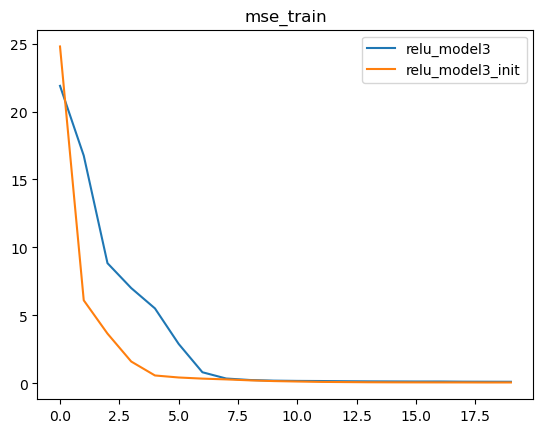

In [36]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

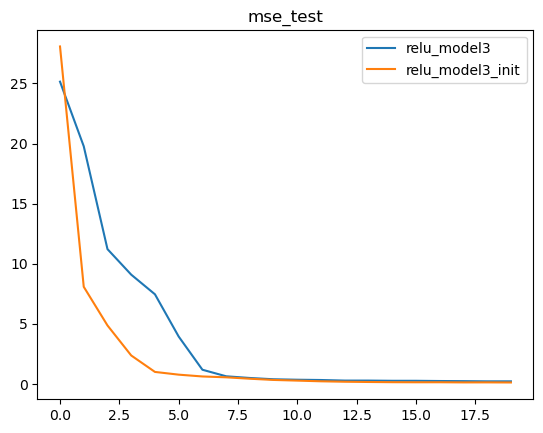

In [37]:
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')